In [1]:
from bvp import our_own_bvp_solve
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_bvp
%matplotlib inline

In [2]:
# The following is the system for the midterm.
gamma = 5 / 3
v_plus = 3 / 5
v_star = gamma / (gamma + 2)
e_minus = (gamma + 2) * (v_plus - v_star) / 2 / gamma / (gamma + 1)

# ODE
f = lambda x, y: np.array([y[0] * (y[0] - 1) + gamma * (y[1] - y[0] * e_minus),
                           y[0] * (-(y[0] - 1) ** 2 / 2 + y[1] - e_minus + gamma * e_minus * (y[0] - 1))])

a = -20
b = 20
dim = 2

# Choose an appropriate number of points at which to collocate.
n = 40

In [3]:
# fixed points
source = np.array([1, e_minus])
sink = np.array([0, 0])
saddle = np.array([v_plus, 3 * e_minus])

In [4]:
# These conditions start at the source and move to the sink.
source_to_sink_bc = lambda ya, yc, yb: np.array([
    *(ya[0] - source),          # start at source
    *(yb[0] - sink),            # finish at the sink
    yb[1][0] + yb[1][1] * 0.33  # specify slope at sink
])

# These conditions were what we tried using for our own solver,
# but we were never able to get the right connecting orbit for
# starting at the source and moving to the saddle.
source_to_saddle_bc = lambda ya, yb: np.array([
    np.dot(yb[0] - saddle, np.array([1, -0.3])),  # specify slope at saddle
    yc[0][0] - (1 + v_plus) / 2                   # phase condition between source and saddle
])

# These conditions work with scipy.integrate.solve_bvp
saddle_hat = saddle + np.array([1e-5, -1e-5])
source_to_saddle_bc = lambda ya, yb: np.array([
    *(yb - saddle_hat)
])

# These conditions start at the saddle and move to the sink.
saddle_to_sink_bc = lambda ya, yc, yb: np.array([
    *(ya[0] - saddle),          # start at saddle
    *(yb[0] - sink),            # finish at sink
    ya[1][0] + ya[1][1] * -0.3  # specify slope at saddle
])

In [5]:
# initial guess for solution
y0_1 = lambda x: np.array([0 for _ in range(len(x))])
y0_2 = lambda x: np.array([0 for _ in range(len(x))])

# # solve for two of the connecting orbits using our_own_bvp_solve
source_to_sink_solution = our_own_bvp_solve(f, a, b, n, (y0_1, y0_2), dim, source_to_sink_bc)
saddle_to_sink_solution = our_own_bvp_solve(f, a, b, n, (y0_1, y0_2), dim, saddle_to_sink_bc)

# different initial guess for source to saddle using solve_bvp
y0_1 = lambda x: (1 + v_plus) / 2 + (v_plus - 1) / 2 * np.tanh(x)
y0_2 = lambda x: 2 * e_minus + e_minus * np.tanh(x)

# The following doesn't work:
# source_to_saddle_solution = our_own_bvp_solve(f, a, b, n, (y0_1, y0_2), dim, source_to_saddle_bc)
# Instead we use solve_bvp
dom = np.linspace(a, b, 100)
source_to_saddle_solution = solve_bvp(f, source_to_saddle_bc, dom, np.vstack((y0_1(dom), y0_2(dom))))

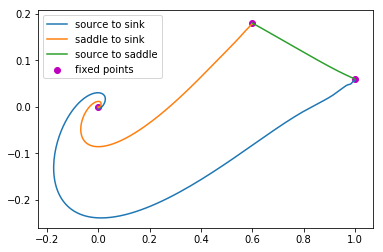

In [6]:
# plotting
dom = np.linspace(a, b, 1000)
plt.plot(source_to_sink_solution[0](dom), source_to_sink_solution[1](dom), label='source to sink')
plt.plot(saddle_to_sink_solution[0](dom), saddle_to_sink_solution[1](dom), label='saddle to sink')
plt.plot(source_to_saddle_solution.sol(dom)[0], source_to_saddle_solution.sol(dom)[1], label='source to saddle')
plt.scatter([1, 0, 3 / 5], [3 / 50, 0, 9 / 50], color='m', label='fixed points')
plt.legend()
plt.show()

### We were able to use `our_own_bvp_solve` to solve for the blue and orange connecting orbits, but we were unable to use it for the green.